# OCR-Devanagari-CRNN — Dataset Analysis & Project Scaffold

This notebook documents the plan to create an OCR for Devanagari using CRNN + LSTM and uses the HuggingFace dataset "Sakonii/nepalitext-language-model-dataset" together with TextRecognitionDataGenerator (TRDG) to synthesize training images. The next cell runs a small scaffold script that will create the repository structure and placeholder modules.

In [ ]:
# # Create project scaffold (runs the script that writes folders/files)
# import runpy
# import os
# proj_root = r"c:\Users\gaurav\OneDrive\Desktop\Computer Vision"
# init_script = os.path.join(proj_root, 'scripts', 'init_project.py')
# if os.path.exists(init_script):
#     runpy.run_path(init_script, run_name='__main__')
# else:
#     print('Scaffold script not found. Please run scripts/init_project.py manually after creating it.')

Next steps:
1. Install requirements (see requirements.txt).
2. Use data/data_loader.py to load the HF dataset and generate images with TRDG.
3. Implement training loop in scripts/train.py using model/ocr_model.py.

In [2]:
!pip install --upgrade pip setuptools

!pip install -r requirements.txt

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)


ERROR: To modify pip, please run the following command:
C:\Users\gaurav\miniconda3\envs\opencv\python.exe -m pip install --upgrade pip setuptools


  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached trdg-1.8.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl.metadata (2.4 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached huggingface_hub-1.1.4-py3-none-any.whl.metadata (13 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached hf_xet-1.2.0-

Requested arabic-reshaper==2.1.3 from https://files.pythonhosted.org/packages/47/27/7b9b824f5342d8ee180027333f2e15842ea36f5bc2d3d24a4e6bb31fb596/arabic_reshaper-2.1.3-py3-none-any.whl (from trdg->-r requirements.txt (line 6)) has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^
Please use pip<24.1 if you need to use this version.
  DEPRECATION: Building 'trdg' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'trdg'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [1]:
from datasets import load_dataset
from PIL import Image
import numpy as np
from trdg.generators import (
    GeneratorFromDict,
    GeneratorFromRandom,
    GeneratorFromStrings,
    GeneratorFromWikipedia,
)  # If you want to generate synthetic images

import matplotlib.pyplot as plt
import itertools #counters and iterators
import random
import re #regular expressions

Missing modules for handwritten text generation.


In [2]:
import sys
print(sys.executable)


c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Scripts\python.exe


In [3]:
# Load the NepaliText dataset
dataset = load_dataset("Sakonii/nepalitext-language-model-dataset")





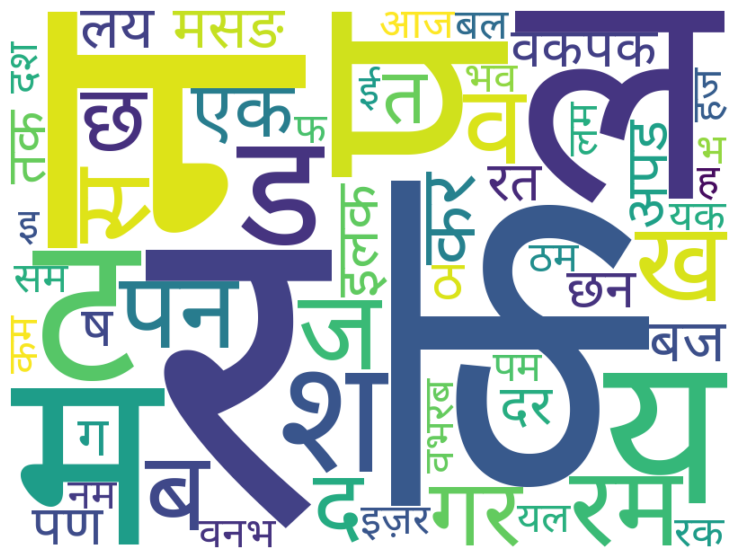

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract first 5 text samples (or use the entire dataset)
train_data = dataset["train"]
texts = train_data["text"][:5]

# Join all text into one string
full_text = " ".join(texts)

# IMPORTANT: Use a font that supports Devanagari characters  
# Download a Devanagari-compatible font (e.g., "NotoSansDevanagari-Regular.ttf")
font_path = r"fonts\NotoSansDevanagari-Regular.ttf"

# Create the word cloud
wc = WordCloud(
    font_path=font_path,
    width=800,
    height=600,
    background_color="white"
).generate(full_text)

# Display the cloud
plt.figure(figsize=(10,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# -----------------------------
# 1. COLLECT ALL TEXT FROM THE DATASET
# -----------------------------

all_texts = []

for split in dataset.keys():      # e.g., "train", "test", "validation"
    print(f"Loading split: {split}")
    for text in dataset[split]["text"]:
        if isinstance(text, str):
            all_texts.append(text)

# Join all text into one string
full_text = " ".join(all_texts)
print("Total characters collected:", len(full_text))

# -----------------------------
# 2. SET A DEVANAGARI FONT PATH
# -----------------------------

# Download one of these and provide path:
# 🔹 NotoSansDevanagari-Regular.ttf
# 🔹 NotoSerifDevanagari-Regular.ttf
# 🔹 Lohit-Devanagari.ttf

font_path = r"fonts\NotoSansDevanagari-Regular.ttf"

# -----------------------------
# 3. GENERATE WORD CLOUD
# -----------------------------

wc = WordCloud(
    font_path=font_path,   # REQUIRED for Devanagari
    width=1600,
    height=1200,
    background_color="white"
).generate(full_text)

# -----------------------------
# 4. DISPLAY
# -----------------------------

plt.figure(figsize=(14,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Loading split: train
Loading split: test


MemoryError: 

Unique characters: 5541


C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\412131526.py:36: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sa

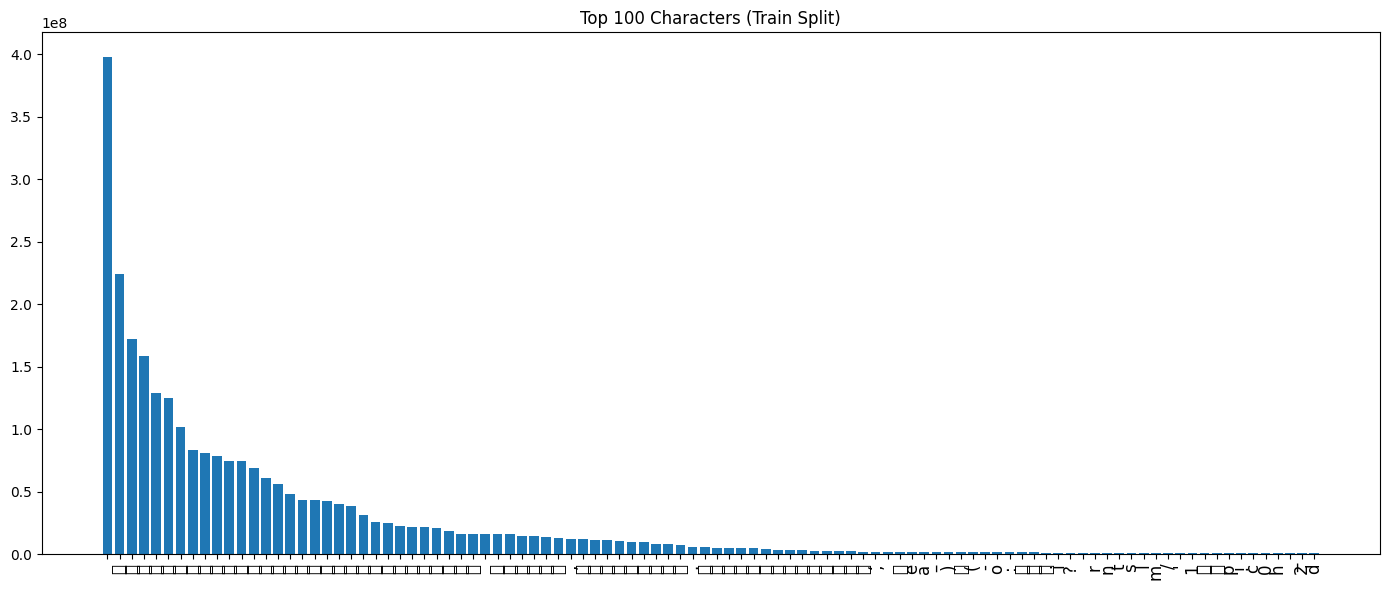

ValueError: anchor not supported for multiline text

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# -------------------------------
# 1. EXTRACT TRAIN DATA ONLY
# -------------------------------
train_texts = dataset["train"]["text"]

# Devanagari font
font_path = r"fonts\NotoSansDevanagari-Regular.ttf"

# -------------------------------
# 2. CHARACTER FREQUENCY (stream-safe)
# -------------------------------
char_freq = Counter()

for text in train_texts:
    if isinstance(text, str):
        char_freq.update(text)

print("Unique characters:", len(char_freq))


# -------------------------------
# 3. TOP 100 CHARACTERS
# -------------------------------
top_100_chars = char_freq.most_common(100)
top_chars, top_freqs = zip(*top_100_chars)

plt.figure(figsize=(14, 6))
plt.bar(top_chars, top_freqs)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 100 Characters (Train Split)")
plt.tight_layout()
plt.show()


# -------------------------------
# 4. CHARACTER FREQUENCY WORDCLOUD
# -------------------------------
wc_char = WordCloud(
    font_path=font_path,
    width=1400,
    height=1000,
    background_color="white"
).generate_from_frequencies(char_freq)

plt.figure(figsize=(14, 10))
plt.imshow(wc_char, interpolation="bilinear")
plt.axis("off")
plt.title("Character Frequency Cloud (Train Split)")
plt.show()


# -------------------------------
# 5. BIGRAM + TRIGRAM FREQUENCY
# -------------------------------
bigram_freq = Counter()
trigram_freq = Counter()

for text in train_texts:
    if not isinstance(text, str):
        continue

    # Remove spaces for Devanagari char-grams
    chars = [ch for ch in text if ch.strip() != ""]

    # bigrams
    for i in range(len(chars) - 1):
        bigram = chars[i] + chars[i+1]
        bigram_freq[bigram] += 1

    # trigrams
    for i in range(len(chars) - 2):
        trigram = chars[i] + chars[i+1] + chars[i+2]
        trigram_freq[trigram] += 1


# -------------------------------
# 6. TOP BIGRAMS & TRIGRAMS
# -------------------------------
top_bigrams = bigram_freq.most_common(20)
top_trigrams = trigram_freq.most_common(20)

# Plot bigrams
bi_labels, bi_vals = zip(*top_bigrams)

plt.figure(figsize=(14, 6))
plt.bar(bi_labels, bi_vals)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 20 Bigrams (Train Split)")
plt.tight_layout()
plt.show()

# Plot trigrams
tri_labels, tri_vals = zip(*top_trigrams)

plt.figure(figsize=(14, 6))
plt.bar(tri_labels, tri_vals)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 20 Trigrams (Train Split)")
plt.tight_layout()
plt.show()


# -------------------------------
# 7. HEATMAP FOR CHARACTER DISTRIBUTION
# -------------------------------
chars_sorted = sorted(char_freq.keys())
freq_values = np.array([char_freq[c] for c in chars_sorted]).reshape(1, -1)

plt.figure(figsize=(20, 3))
plt.imshow(freq_values, aspect="auto")
plt.xticks(range(len(chars_sorted)), chars_sorted, fontsize=10, rotation=90)
plt.yticks([])
plt.colorbar(label="Frequency")
plt.title("Character Distribution Heatmap (Train Split)")
plt.show()


Unique cleaned characters: 5314


C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_10232\646200413.py:53: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sa

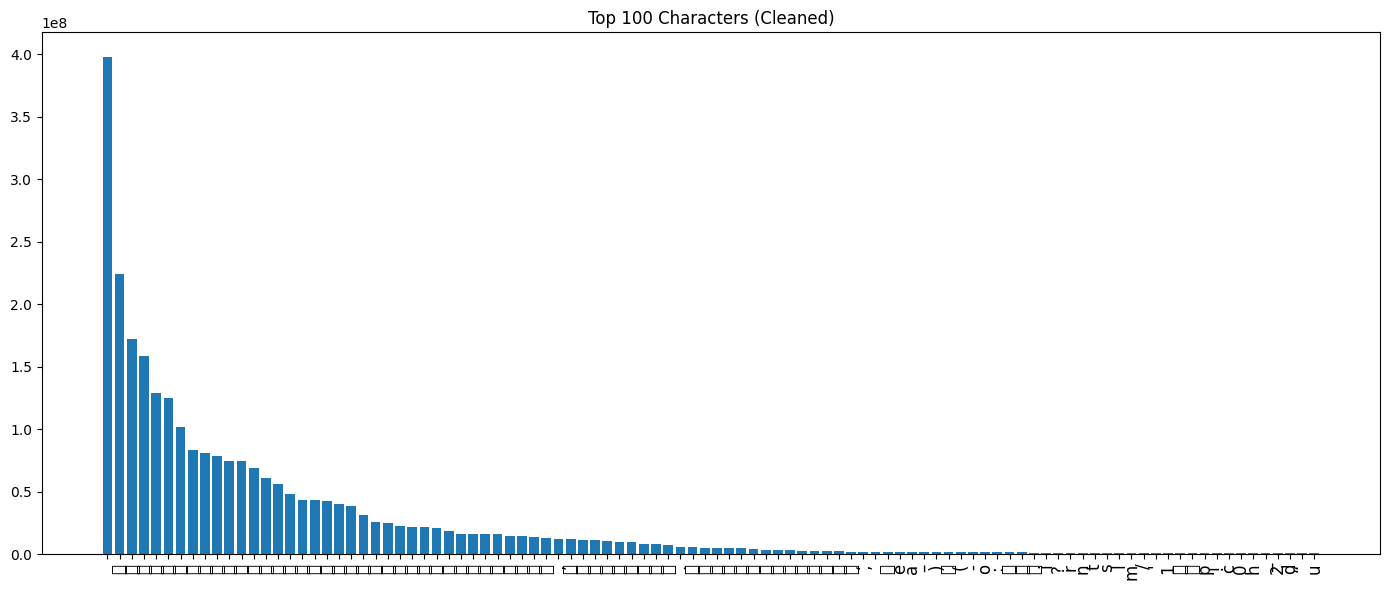

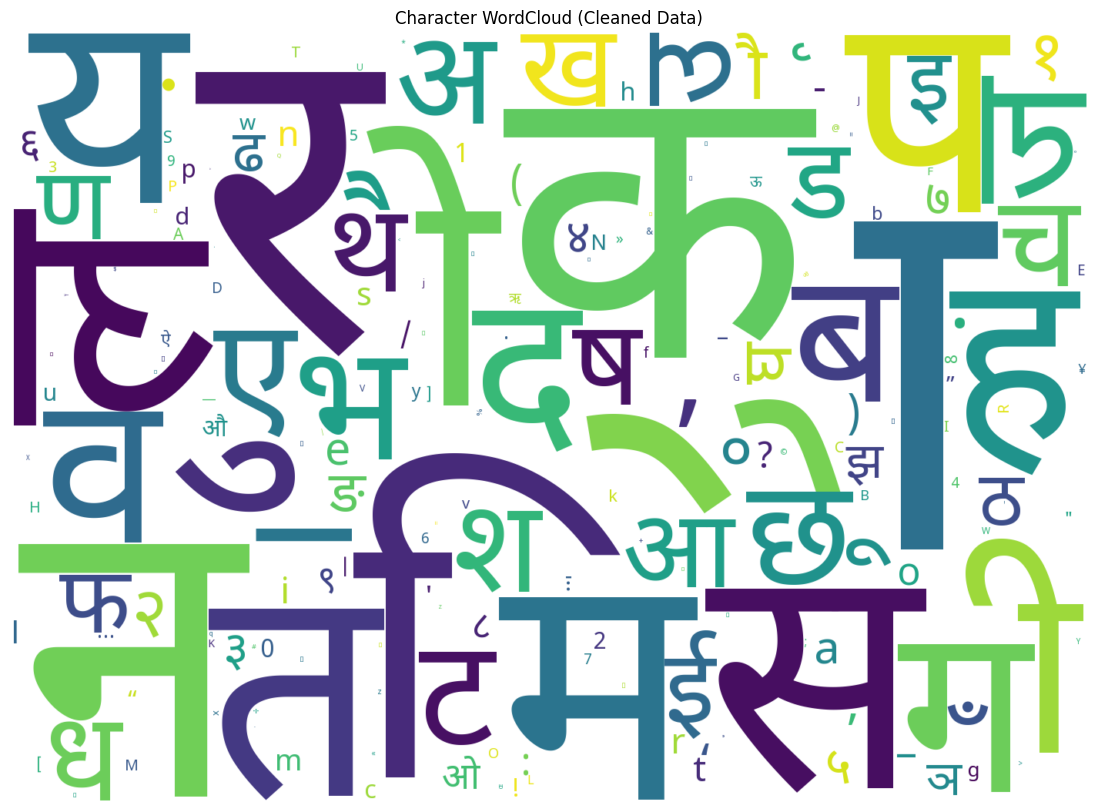

KeyboardInterrupt: 

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# -----------------------------------
# CLEANING FUNCTION
# -----------------------------------
def clean_char(c):
    if c in ["\n", "\t", "\r"]:
        return ""
    if ord(c) in [8203, 8204, 8205, 8206, 8207]:
        return ""
    if 2304 <= ord(c) <= 2431:  # Devanagari block
        return c
    if c.isprintable():
        return c
    return ""


# -----------------------------------
# LOAD TRAIN DATA
# -----------------------------------
train_texts = dataset["train"]["text"]

font_path = r"fonts\NotoSansDevanagari-Regular.ttf"

# -----------------------------------
# CHARACTER FREQUENCY
# -----------------------------------
char_freq = Counter()

for text in train_texts:
    if not isinstance(text, str):
        continue

    cleaned = "".join(clean_char(c) for c in text)
    char_freq.update(cleaned)

print("Unique cleaned characters:", len(char_freq))


# -----------------------------------
# TOP 100 CHARACTER BAR CHART
# -----------------------------------
top_100 = char_freq.most_common(100)
chars, freqs = zip(*top_100)

plt.figure(figsize=(14, 6))
plt.bar(chars, freqs)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 100 Characters (Cleaned)")
plt.tight_layout()
plt.show()


# -----------------------------------
# CHARACTER WORDCLOUD (SAFE)
# -----------------------------------
wc_char = WordCloud(
    font_path=font_path,
    width=1400,
    height=1000,
    background_color="white"
).generate_from_frequencies(char_freq)

plt.figure(figsize=(14, 10))
plt.imshow(wc_char, interpolation="bilinear")
plt.axis("off")
plt.title("Character WordCloud (Cleaned Data)")
plt.show()


# -----------------------------------
# BIGRAM + TRIGRAM FREQUENCY
# -----------------------------------
bigram_freq = Counter()
trigram_freq = Counter()

for text in train_texts:
    if not isinstance(text, str):
        continue

    cleaned = [clean_char(c) for c in text if clean_char(c) != ""]

    # bigrams
    for i in range(len(cleaned) - 1):
        bigram_freq[cleaned[i] + cleaned[i+1]] += 1

    # trigrams
    for i in range(len(cleaned) - 2):
        trigram_freq[cleaned[i] + cleaned[i+1] + cleaned[i+2]] += 1


# -----------------------------------
# TOP 20 BIGRAMS
# -----------------------------------
top_bi = bigram_freq.most_common(20)
bi_labels, bi_vals = zip(*top_bi)

plt.figure(figsize=(14, 6))
plt.bar(bi_labels, bi_vals)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 20 Bigrams")
plt.tight_layout()
plt.show()


# -----------------------------------
# TOP 20 TRIGRAMS
# -----------------------------------
top_tri = trigram_freq.most_common(20)
tri_labels, tri_vals = zip(*top_tri)

plt.figure(figsize=(14, 6))
plt.bar(tri_labels, tri_vals)
plt.xticks(rotation=90, fontsize=12)
plt.title("Top 20 Trigrams")
plt.tight_layout()
plt.show()


# -----------------------------------
# CHARACTER DISTRIBUTION HEATMAP
# -----------------------------------
sorted_chars = sorted(char_freq.keys())
values = np.array([char_freq[c] for c in sorted_chars]).reshape(1, -1)

plt.figure(figsize=(18, 3))
plt.imshow(values, aspect="auto")
plt.xticks(range(len(sorted_chars)), sorted_chars, rotation=90, fontsize=10)
plt.colorbar(label="Frequency")
plt.title("Character Distribution Heatmap (Cleaned)")
plt.yticks([])
plt.show()


In [ ]:
import random
from collections import Counter

train_texts = dataset["train"]["text"]

# FAST SAMPLE
SAMPLE_SIZE = 50000   # 10 seconds
sample = random.sample(list(train_texts), min(SAMPLE_SIZE, len(train_texts)))

print("Using sample size:", len(sample))

bigram_freq = Counter()
trigram_freq = Counter()

for text in sample:
    if not isinstance(text, str):
        continue

    cleaned = [clean_char(c) for c in text if clean_char(c) != ""]

    for i in range(len(cleaned) - 1):
        bigram_freq[cleaned[i] + cleaned[i+1]] += 1

    for i in range(len(cleaned) - 2):
        trigram_freq[cleaned[i] + cleaned[i+1] + cleaned[i+2]] += 1

print("Done!")


In [3]:
train_data = dataset["train"]
# Example: Access first 5 text entries
texts = train_data["text"][:5]

# If you want to generate images from these texts using TRDG
# generator = TextGenerator()

# # Create a list of image-text pairs (for OCR)
# image_text_pairs = []
# for text in texts:
#     img = generator.generate(text)
#     img = np.array(img)  # Convert to numpy array for use in PyTorch
#     image_text_pairs.append((img, text))

# # Now image_text_pairs holds the generated images and corresponding texts
# # You can use this for training your OCR model.
train_data[:5]

{'text': ['कार्यालय प्रमुख ः– ०४१–४१४००१\n',
  'सामसङ मोबाइलको नेपाली बजार मूल्य(अपडेट)\n',
  'नेपाल विश्वकपको लागि छनोट\n',
  'नारीदर्पण : नेपाल मुक्तक प्रतिष्ठान इज़रायल शाखाले आज भव्य रुपमा वनभोज कार्यक्रक्रम सम्पन्न गरेको छ ।\n',
  'काठमाडौं । दश दिनमै विश्वभरबाट एक हजार करोड भारूको कीर्तिमानी कमाइ गरेको फिल्म बाहुबली-२ ले नेपालमा पनि दुई सातामै १८ करोड रूपैयाँ जुटाएको छ ।\n']}

In [4]:
len(train_data)

13141222

In [5]:
subset = train_data.select(range(50000)) 
texts = [x["text"] for x in subset]

In [6]:
#COUNTING INDIVIDUAL CHARACTER FREQUENCIES
from collections import Counter

char_counts = Counter("".join(texts))

for ch, freq in char_counts.most_common(50):
    print(repr(ch), freq)


' ' 1510464
'ा' 853611
'्' 655615
'र' 603484
'न' 489500
'क' 476555
'ि' 385922
'े' 315863
'म' 307768
'स' 300218
'ल' 283149
'ो' 282254
'त' 262443
'प' 232494
'य' 213347
'ु' 182993
'ह' 165248
'ी' 164245
'ग' 161330
'व' 153294
'द' 145242
'ब' 119375
'ज' 99652
'भ' 95712
'।' 86195
'ट' 82225
'छ' 81900
'ए' 80135
'ै' 70831
'अ' 62019
'\n' 60701
'श' 60524
'उ' 60202
'च' 59195
'ध' 56937
'थ' 55689
'ष' 52461
'ख' 49228
',' 47568
'ड' 47262
'ं' 42852
'आ' 42696
'ँ' 41138
'ई' 37359
'ण' 36982
'ू' 32008
'फ' 30367
'इ' 27023
'.' 22537
'ठ' 20591


In [7]:
#COUNTING BIGRAM FREQUENCIES (PAIR OF CONSECUTIVE CHARACTERS)

bigrams = Counter()
for line in texts:
    for a, b in zip(line, line[1:]):
        bigrams[(a, b)] += 1

print(bigrams.most_common(50))


[(('ा', ' '), 235335), (('ो', ' '), 187238), ((' ', 'स'), 143820), (('क', 'ो'), 141804), (('म', 'ा'), 128948), (('र', '्'), 125886), (('क', 'ा'), 124431), (('्', 'र'), 123208), ((' ', 'प'), 119304), (('े', ' '), 112412), (('न', '्'), 101425), (('र', ' '), 99673), (('ा', 'र'), 99428), ((' ', 'क'), 88811), (('्', 'य'), 87507), (('ी', ' '), 82567), (('न', ' '), 79068), ((' ', 'ग'), 78886), (('न', 'े'), 76652), ((' ', 'र'), 70278), (('ल', 'े'), 68426), ((' ', 'न'), 67396), (('ल', 'ा'), 67350), ((' ', 'म'), 64375), ((' ', 'ब'), 64137), (('ा', 'ल'), 62624), (('ग', 'र'), 62571), ((' ', '।'), 62544), ((' ', 'भ'), 61560), (('त', '्'), 60445), (('स', '्'), 59750), (('्', 'न'), 59101), (('ि', ' '), 58642), (('्', 'त'), 58010), (('।', ' '), 56720), (('र', 'ा'), 56388), ((' ', 'अ'), 55405), ((' ', 'ह'), 54474), (('ा', 'न'), 54370), (('क', '्'), 53957), (('प', '्'), 53132), (('ि', 'क'), 52961), ((' ', 'व'), 51665), (('ए', 'क'), 48523), (('य', 'ा'), 47966), (('न', 'ि'), 47659), ((' ', 'छ'), 46432), (

In [8]:
#COUNTING HALANTA CONJUNCTS [PRECEDING CHARACTER + ् +  FOLLOWING CHARACTER = CONJUNCT ( EG: प +  ् + र = प्र) ]
halanta_count = char_counts["्"]

conjuncts = Counter()
for line in texts:
    idx = line.find("्")
    while idx != -1 and idx < len(line)-1:
        conjunct = line[idx-1 : idx+2]  # e.g. 'क्र'
        conjuncts[conjunct] += 1
        idx = line.find("्", idx+1)

print(conjuncts.most_common(20))


[('प्र', 46776), ('त्र', 28028), ('र्न', 27546), ('क्ष', 20000), ('न्त', 19102), ('न्द', 16734), ('स्थ', 16017), ('स्त', 15270), ('त्य', 14938), ('र्य', 14178), ('न् ', 13783), ('क्र', 12095), ('न्छ', 10860), ('न्न', 10647), ('ष्ट', 9415), ('क्त', 8667), ('र्व', 8636), ('र्द', 8537), ('व्य', 8277), ('र्म', 8082)]


In [9]:
#COUNTING WORD FREQUENCIES
word_counts = Counter()

for line in texts:
    words = re.findall(r"\S+", line)
    word_counts.update(words)

print(word_counts.most_common(50))


[('।', 64600), ('र', 26319), ('छ', 19719), ('पनि', 13197), ('भएको', 9520), ('लागि', 8169), ('गरेको', 6985), ('गर्न', 6783), ('छन्', 6660), ('तथा', 6438), ('गर्ने', 6341), ('हो', 6227), ('यो', 5722), ('भने', 5179), ('एक', 4953), ('नै', 4434), ('नेपाल', 4343), ('हुने', 4229), ('रहेको', 4038), ('नेपाली', 3830), ('थियो', 3759), ('छ।', 3558), ('को', 3290), ('गरेका', 3195), ('मा', 3140), ('तर', 2992), ('उनले', 2960), ('गरिएको', 2944), ('काम', 2910), ('?', 2876), ('भन्ने', 2737), ('आफ्नो', 2673), ('गर्दै', 2593), ('गरी', 2533), ('हुन', 2416), ('केही', 2353), ('भएका', 2317), ('नयाँ', 2304), ('दिन', 2303), ('त', 2298), ('थिए', 2231), ('कुनै', 2207), ('दुई', 2157), ('हुन्छ', 2097), ('कुरा', 2070), (':', 2066), ('हजार', 2061), ('वा', 2049), ('धेरै', 2042), ('यस', 2018)]


In [10]:
lengths = [len(t) for t in texts]

print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Max:", np.max(lengths))
print("Min:", np.min(lengths))


Mean: 203.19252
Median: 74.0
Max: 83923
Min: 0


In [11]:
allowed = set("".join(char_counts.keys()))
for t in texts[:2000]:
    if any(ord(c) > 2000 for c in t):  # rough threshold
        print(t)


कार्यालय प्रमुख ः– ०४१–४१४००१

सामसङ मोबाइलको नेपाली बजार मूल्य(अपडेट)

नेपाल विश्वकपको लागि छनोट

नारीदर्पण : नेपाल मुक्तक प्रतिष्ठान इज़रायल शाखाले आज भव्य रुपमा वनभोज कार्यक्रक्रम सम्पन्न गरेको छ ।

काठमाडौं । दश दिनमै विश्वभरबाट एक हजार करोड भारूको कीर्तिमानी कमाइ गरेको फिल्म बाहुबली-२ ले नेपालमा पनि दुई सातामै १८ करोड रूपैयाँ जुटाएको छ ।

नेपालको संविधान

मौलिक हकसम्बन्धी कानुन कहिले बन्छ ? (भिडियो) _ ImageKhabar <!-instant articles-->

चलचित्रको यूरोप प्रदर्शनकाे लागि भने डेनमार्कबाट सुरु हुँदैछ । डेनमार्कपछि पोल्याण्ड, स्पेन, पोर्चुगल, जर्मन लगायतका १० वटा देशमा पनि चलचित्र देखाइनेछ । कतार, ओमान, जापान, बहराइन लगायतका देशमा पनि प्रदर्शन गरिनेछ ।

प्रदेश नं. ७

‘प्रेस स्वतन्त्रतामा कुनै हस्तक्षेप हुँदैन’

‘केपी ओली राजा महेन्द्र भन्दा निरंकुश’

सन् १८८१मा उनी फ्रेन्च एकेडेमीका सदस्य चुनिए। त्यसबखत उनलाई भिक्टर हृयुगोको समानान्तर कवि मानिन्थ्यो।आफ्नो जीवनको अन्तिम क्षणमा उनी 'पक्षघात'बाट पीडित थिए।त्यही समयबीच उनले ललितकला, छन्द शास्त्र र काव्य सिद्धान्तमाथि केही निबन्धहरू पनि लेखे

In [12]:
bad_lines = [t for t in texts if any(ord(c) < 32 for c in t)]


In [13]:
fonts = [
    "fonts/NotoSansDevanagari-Regular.ttf",
    "fonts/NotoSansDevanagari-Medium.ttf",
    "fonts/NotoSansDevanagari-Bold.ttf",
    "fonts/NotoSerifDevanagari-Regular.ttf"
]


In [13]:
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

def render_text(output_path, font_path, render_text, font_size=34, image_dpi=(300, 300)):
    try:
        font = ImageFont.truetype(font_path, font_size, layout_engine=ImageFont.Layout.RAQM)
    except Exception as e:
        print(f"Error loading font: {e}")
        return

    margin = 20
    bbox = font.getbbox(render_text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    image_width = text_width + 2 * margin
    image_height = text_height + 2 * margin

    image = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(image)

    x = (image_width - text_width) // 2
    y = (image_height - text_height) // 2

    draw.text((x, y), render_text, font=font, fill="black")

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)

    try:
        image.save(output_path, dpi=image_dpi)
    except Exception as e:
        print(f"Error saving image: {e}")


# 👉 DEFINE FONT PATH HERE
font_link_Noto_Sans_devanagari = r"C:\fonts\NotoSansDevanagari-Regular.ttf"

otp_path = r"test_images\sag_test.png"

render_text(
    otp_path,
    font_link_Noto_Sans_devanagari,
    "बताएका छन्। त्यहाँ समुद्री तटको बाटोछेउमा झुम्मिछन्"
)


Error loading font: cannot open resource


c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\PIL\ImageFont.py:244: UserWarning: Raqm layout was requested, but Raqm is not available. Falling back to basic layout.
  warnings.warn(


In [15]:
from PIL import Image

# Patch ANTIALIAS for Pillow >= 10
if not hasattr(Image, "ANTIALIAS"):
    Image.ANTIALIAS = Image.Resampling.LANCZOS


In [16]:
test_strings = ["नेपाल", "संयुक्त", "काठमाण्डौ", "विद्यालय", "क्षेत्र", "कृषि"]

gen = GeneratorFromStrings(
    strings=test_strings,
    fonts=fonts,
    size=42,
    random_blur=True,         # supported
    random_skew=True,         # use this instead of rotation
    distorsion_type=2,        # 1=sin, 2=cos, 3=random
    background_type=1,        # 0: plain white, 1: noisy, 2: patterned
)


In [17]:
import os
import glob
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import cv2


class AdvancedOCRDatasetGenerator:
    """
    Generate OCR dataset images with Devanagari text.
    Includes blur, noise, rotation, distortion, safe resizing.
    """

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/images",
        size=42,
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background="white",
    ):
        self.strings = strings

        # Load fonts
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if len(self.fonts) == 0:
            raise ValueError(f"No .ttf fonts found in {fonts_dir}")

        # Output directory
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.size = size
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background = background

        # Image size cap (prevents MemoryError)
        self.MAX_SIZE = 1024

    # -------------------------------------------------------------------
    # SAFE SIZE CLAMP
    # -------------------------------------------------------------------
    def _clamp_image_size(self, img, max_size=None):
        """Ensure image never exceeds max_size in any direction."""
        if max_size is None:
            max_size = self.MAX_SIZE

        w, h = img.size
        if w > max_size or h > max_size:
            img.thumbnail((max_size, max_size), Image.LANCZOS)
        return img

    # -------------------------------------------------------------------
    # MAIN DATASET GENERATOR
    # -------------------------------------------------------------------
    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.generate_image(text)

            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.gt.txt")

            img.save(image_path)

            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"[{idx}/{len(self.strings)}] Saved: {image_path}")

    # -------------------------------------------------------------------
    # IMAGE GENERATOR
    # -------------------------------------------------------------------
    def generate_image(self, text):

        # Choose random font
        font_path = random.choice(self.fonts)
        font = ImageFont.truetype(font_path, self.size, layout_engine=ImageFont.Layout.RAQM)

        # Bounding box
        bbox = font.getbbox(text)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        pad = 20

        # Background
        if self.background == "white":
            img = Image.new("RGB", (w + pad * 2, h + pad * 2), "white")
        else:
            img = self.generate_background(w + pad * 2, h + pad * 2)

        # Draw text
        draw = ImageDraw.Draw(img)
        draw.text((pad, pad), text, fill="black", font=font)

        # Clamp immediately
        img = self._clamp_image_size(img)

        # --------------------------------------
        # BLUR
        # --------------------------------------
        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # --------------------------------------
        # ROTATION (safe)
        # --------------------------------------
        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor="white")
            img = self._clamp_image_size(img)

        # --------------------------------------
        # DISTORTION (safe)
        # --------------------------------------
        if self.random_distortion:
            img = self.perspective_distortion(img)
            img = self._clamp_image_size(img)

        # --------------------------------------
        # NOISE
        # --------------------------------------
        if self.random_noise:
            img = self.add_noise(img)

        return img

    # -------------------------------------------------------------------
    # RANDOM BACKGROUND
    # -------------------------------------------------------------------
    def generate_background(self, w, h):
        arr = np.random.randint(200, 255, (h, w, 3), dtype=np.uint8)
        return Image.fromarray(arr)

    # -------------------------------------------------------------------
    # GAUSSIAN + SALT & PEPPER NOISE
    # -------------------------------------------------------------------
    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)

        # Gaussian noise
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)

        # Salt & pepper
        if random.random() < 0.5:
            amount = 0.02
            s_vs_p = 0.5
            num_salt = int(arr.size * amount * s_vs_p)
            num_pepper = int(arr.size * amount * (1 - s_vs_p))

            coords = tuple(np.random.randint(0, i - 1, num_salt) for i in arr.shape)
            arr[coords] = 255

            coords = tuple(np.random.randint(0, i - 1, num_pepper) for i in arr.shape)
            arr[coords] = 0

        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))

    # -------------------------------------------------------------------
    # PERSPECTIVE DISTORTION (SAFE)
    # -------------------------------------------------------------------
    def perspective_distortion(self, img):
        # Resize before distortion
        img = self._clamp_image_size(img)

        w, h = img.size
        arr = np.array(img)

        # Shift
        shift = min(w, h) * 0.10

        pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)

        warped = cv2.warpPerspective(
            arr,
            matrix,
            (w, h),
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(255, 255, 255)
        )

        img = Image.fromarray(warped)
        return self._clamp_image_size(img)   # Safety clamp


# END OF CLASS


In [24]:
import os
import glob
import random
import numpy as np
from PIL import Image, ImageFilter
import freetype
import uharfbuzz as hb
import cv2

class HarfBuzzOCRDatasetGenerator:
    """
    Generate OCR dataset images with properly shaped Devanagari text
    using FreeType + HarfBuzz. Supports blur, noise, rotation, distortion.
    """

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/images",
        font_size=48,
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background="white",
    ):
        self.strings = strings
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if not self.fonts:
            raise ValueError(f"No fonts found in {fonts_dir}")

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.font_size = font_size
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background = background
        self.MAX_SIZE = 1024

    # -------------------------------
    def _clamp_image_size(self, img):
        w, h = img.size
        if w > self.MAX_SIZE or h > self.MAX_SIZE:
            img.thumbnail((self.MAX_SIZE, self.MAX_SIZE), Image.LANCZOS)
        return img

    # -------------------------------
    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.render_text_image(text)

            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.gt.txt")

            img.save(image_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"[{idx}/{len(self.strings)}] Saved: {image_path}")

    # -------------------------------
    def render_text_image(self, text, padding=20):
        # Choose random font
        font_path = random.choice(self.fonts)
        face = freetype.Face(font_path)
        face.set_char_size(self.font_size * 64)

        # HarfBuzz shaping
        hb_blob = hb.Blob.from_file_path(font_path)
        hb_face = hb.Face(hb_blob, 0)
        hb_font = hb.Font(hb_face)
        hb_font.scale = (face.size.ascender, face.size.ascender)

        buf = hb.Buffer()
        buf.add_str(text)
        buf.guess_segment_properties()
        hb.shape(hb_font, buf)

        infos = buf.glyph_infos
        positions = buf.glyph_positions

        width = sum(pos.x_advance for pos in positions) // 64 + 2*padding
        height = self.font_size + 2*padding

        # Background
        if self.background == "white":
            img = Image.new("RGB", (width, height), "white")
        else:
            arr = np.random.randint(200, 255, (height, width, 3), dtype=np.uint8)
            img = Image.fromarray(arr)

        x, y = padding, padding + self.font_size

        # Render glyphs
        for info, pos in zip(infos, positions):
            glyph_index = info.codepoint
            face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
            bitmap = face.glyph.bitmap
            top = face.glyph.bitmap_top
            left = face.glyph.bitmap_left

            if bitmap.width > 0 and bitmap.rows > 0:
                glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
                colored_glyph = Image.new("RGB", glyph_img.size, "black")
                img.paste(colored_glyph, (int(x + left), int(y - top)), glyph_img)

            x += pos.x_advance / 64
            y -= pos.y_advance / 64

        img = self._clamp_image_size(img)

        # Random blur
        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # Random rotation
        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor="white")
            img = self._clamp_image_size(img)

        # Random distortion
        if self.random_distortion:
            img = self.perspective_distortion(img)

        # Random noise
        if self.random_noise:
            img = self.add_noise(img)

        return img

    # -------------------------------
    def perspective_distortion(self, img):
        img = self._clamp_image_size(img)
        w, h = img.size
        arr = np.array(img)
        shift = min(w, h) * 0.1

        pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(arr, matrix, (w, h),
                                     borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(255, 255, 255))
        return Image.fromarray(warped)

    # -------------------------------
    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)
        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))


In [25]:
strings = [
    "कार्यालय प्रमुख ः ०४१४१४००१",
    "नेपाल विश्वकपको लागि छनोट",
    "सामसङ मोबाइलको नेपाली बजार मूल्य"
]

generator = HarfBuzzOCRDatasetGenerator(
    strings=strings,
    fonts_dir="fonts",
    output_dir="data/images",
    font_size=48,
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background="white"
)

generator.generate_dataset()


[1/3] Saved: data/images\00001.png
[2/3] Saved: data/images\00002.png
[3/3] Saved: data/images\00003.png


In [27]:
# -----------------------------
# 1️⃣ Assume you already have cleaned_strings from your cleaning step
# -----------------------------
# cleaned_strings = [...]  # your preprocessed Nepali text list

# -----------------------------
# 2️⃣ Import the dataset generator
# -----------------------------
# Make sure HarfBuzzOCRDatasetGenerator class (from previous code) is defined or imported

# -----------------------------
# 3️⃣ Create generator using cleaned Nepali text
# -----------------------------
generator = HarfBuzzOCRDatasetGenerator(
    strings=cleaned_strings,          # use your cleaned Nepali text list
    fonts_dir="fonts",                # folder containing .ttf Devanagari fonts
    output_dir="data/images",         # folder to save generated images and labels
    font_size=48,                     # base font size (can later randomize per image)
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background="white"                # you can also try "random" for textures
)

# -----------------------------
# 4️⃣ Generate dataset
# -----------------------------
generator.generate_dataset()


[1/1802] Saved: data/images\00001.png
[2/1802] Saved: data/images\00002.png
[3/1802] Saved: data/images\00003.png
[4/1802] Saved: data/images\00004.png
[5/1802] Saved: data/images\00005.png
[6/1802] Saved: data/images\00006.png
[7/1802] Saved: data/images\00007.png
[8/1802] Saved: data/images\00008.png
[9/1802] Saved: data/images\00009.png
[10/1802] Saved: data/images\00010.png
[11/1802] Saved: data/images\00011.png
[12/1802] Saved: data/images\00012.png
[13/1802] Saved: data/images\00013.png
[14/1802] Saved: data/images\00014.png
[15/1802] Saved: data/images\00015.png
[16/1802] Saved: data/images\00016.png
[17/1802] Saved: data/images\00017.png
[18/1802] Saved: data/images\00018.png
[19/1802] Saved: data/images\00019.png
[20/1802] Saved: data/images\00020.png
[21/1802] Saved: data/images\00021.png
[22/1802] Saved: data/images\00022.png
[23/1802] Saved: data/images\00023.png
[24/1802] Saved: data/images\00024.png
[25/1802] Saved: data/images\00025.png
[26/1802] Saved: data/images\00026

In [28]:
import os
import glob
import random
import numpy as np
from PIL import Image, ImageFilter
import freetype
import uharfbuzz as hb
import cv2

class SyntheticHarfBuzzOCRDatasetGenerator:
    """
    Generate fully synthetic OCR dataset images with properly shaped
    Devanagari text using FreeType + HarfBuzz.
    Supports random font size, backgrounds, noise, blur, rotation, distortion.
    """

    def __init__(
        self,
        strings,
        fonts_dir="fonts",
        output_dir="data/images",
        font_size_range=(40, 64),
        random_blur=True,
        random_noise=True,
        random_rotate=True,
        random_distortion=True,
        background_mode="random",  # "white", "lightgray", or "random"
        max_image_size=1024
    ):
        self.strings = strings
        self.fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
        if not self.fonts:
            raise ValueError(f"No fonts found in {fonts_dir}")

        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.font_size_range = font_size_range
        self.random_blur = random_blur
        self.random_noise = random_noise
        self.random_rotate = random_rotate
        self.random_distortion = random_distortion
        self.background_mode = background_mode
        self.MAX_SIZE = max_image_size

    # -----------------------------------------------
    def _clamp_image_size(self, img):
        w, h = img.size
        if w > self.MAX_SIZE or h > self.MAX_SIZE:
            img.thumbnail((self.MAX_SIZE, self.MAX_SIZE), Image.LANCZOS)
        return img

    # -----------------------------------------------
    def generate_dataset(self):
        for idx, text in enumerate(self.strings, start=1):
            img = self.render_text_image(text)

            image_path = os.path.join(self.output_dir, f"{idx:05d}.png")
            label_path = os.path.join(self.output_dir, f"{idx:05d}.gt.txt")

            img.save(image_path)
            with open(label_path, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"[{idx}/{len(self.strings)}] Saved: {image_path}")

    # -----------------------------------------------
    def render_text_image(self, text, padding=20):
        # Random font & size
        font_path = random.choice(self.fonts)
        font_size = random.randint(*self.font_size_range)
        face = freetype.Face(font_path)
        face.set_char_size(font_size * 64)

        # HarfBuzz shaping
        hb_blob = hb.Blob.from_file_path(font_path)
        hb_face = hb.Face(hb_blob, 0)
        hb_font = hb.Font(hb_face)
        hb_font.scale = (face.size.ascender, face.size.ascender)

        buf = hb.Buffer()
        buf.add_str(text)
        buf.guess_segment_properties()
        hb.shape(hb_font, buf)

        infos = buf.glyph_infos
        positions = buf.glyph_positions

        width = sum(pos.x_advance for pos in positions) // 64 + 2*padding
        height = font_size + 2*padding

        # Background
        if self.background_mode == "white":
            img = Image.new("RGB", (width, height), "white")
        elif self.background_mode == "lightgray":
            img = Image.new("RGB", (width, height), "lightgray")
        else:
            arr = np.random.randint(200, 255, (height, width, 3), dtype=np.uint8)
            img = Image.fromarray(arr)

        x, y = padding, padding + font_size

        # Render glyphs
        for info, pos in zip(infos, positions):
            glyph_index = info.codepoint
            face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
            bitmap = face.glyph.bitmap
            top = face.glyph.bitmap_top
            left = face.glyph.bitmap_left

            if bitmap.width > 0 and bitmap.rows > 0:
                glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
                colored_glyph = Image.new("RGB", glyph_img.size, "black")
                img.paste(colored_glyph, (int(x + left), int(y - top)), glyph_img)

            x += pos.x_advance / 64
            y -= pos.y_advance / 64

        img = self._clamp_image_size(img)

        # Random blur
        if self.random_blur and random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # Random rotation
        if self.random_rotate:
            angle = random.randint(-7, 7)
            img = img.rotate(angle, expand=True, fillcolor=(255,255,255))
            img = self._clamp_image_size(img)

        # Random distortion
        if self.random_distortion:
            img = self.perspective_distortion(img)

        # Random noise
        if self.random_noise:
            img = self.add_noise(img)

        return img

    # -----------------------------------------------
    def perspective_distortion(self, img):
        img = self._clamp_image_size(img)
        w, h = img.size
        arr = np.array(img)
        shift = min(w, h) * 0.1

        pts1 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        pts2 = np.float32([
            [random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), random.uniform(-shift, shift)],
            [random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
            [w + random.uniform(-shift, shift), h + random.uniform(-shift, shift)],
        ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(arr, matrix, (w,h),
                                     borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(255,255,255))
        return Image.fromarray(warped)

    # -----------------------------------------------
    def add_noise(self, img):
        arr = np.array(img).astype(np.float32)

        # Gaussian
        if random.random() < 0.5:
            arr += np.random.normal(0, 10, arr.shape)

        # Salt & pepper
        if random.random() < 0.5:
            amount = 0.02
            s_vs_p = 0.5
            num_salt = int(arr.size * amount * s_vs_p)
            num_pepper = int(arr.size * amount * (1 - s_vs_p))

            coords = [np.random.randint(0, i - 1, num_salt) for i in arr.shape]
            arr[tuple(coords)] = 255

            coords = [np.random.randint(0, i - 1, num_pepper) for i in arr.shape]
            arr[tuple(coords)] = 0

        arr = np.clip(arr, 0, 255)
        return Image.fromarray(arr.astype(np.uint8))


In [31]:
generator = SyntheticHarfBuzzOCRDatasetGenerator(
    strings=cleaned_strings,
    fonts_dir="fonts",
    output_dir="data/images",
    font_size_range=(40, 64),
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background_mode="random"
)

generator.generate_dataset()

[1/1802] Saved: data/images\00001.png
[2/1802] Saved: data/images\00002.png
[3/1802] Saved: data/images\00003.png
[4/1802] Saved: data/images\00004.png
[5/1802] Saved: data/images\00005.png
[6/1802] Saved: data/images\00006.png
[7/1802] Saved: data/images\00007.png
[8/1802] Saved: data/images\00008.png
[9/1802] Saved: data/images\00009.png
[10/1802] Saved: data/images\00010.png
[11/1802] Saved: data/images\00011.png
[12/1802] Saved: data/images\00012.png
[13/1802] Saved: data/images\00013.png
[14/1802] Saved: data/images\00014.png
[15/1802] Saved: data/images\00015.png
[16/1802] Saved: data/images\00016.png
[17/1802] Saved: data/images\00017.png
[18/1802] Saved: data/images\00018.png
[19/1802] Saved: data/images\00019.png
[20/1802] Saved: data/images\00020.png
[21/1802] Saved: data/images\00021.png
[22/1802] Saved: data/images\00022.png
[23/1802] Saved: data/images\00023.png
[24/1802] Saved: data/images\00024.png
[25/1802] Saved: data/images\00025.png
[26/1802] Saved: data/images\00026

In [19]:
import sys
print(sys.executable)


c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Scripts\python.exe


In [18]:
# 1️⃣ List of Nepali strings (from Hugging Face)
strings = [
    "नेपाल", "संयुक्त", "काठमाण्डौ",
    "विद्यालय", "क्षेत्र", "कृषि"
]

# 2️⃣ Create generator
generator = AdvancedOCRDatasetGenerator(
    strings=strings,
    fonts_dir="fonts",           # folder where your .ttf fonts are stored
    output_dir="data/images",    # folder to save images + labels
    size=48,
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background="white"
)

# 3️⃣ Generate dataset
generator.generate_dataset()


[1/6] Saved: data/images\00001.png
[2/6] Saved: data/images\00002.png
[3/6] Saved: data/images\00003.png
[4/6] Saved: data/images\00004.png
[5/6] Saved: data/images\00005.png
[6/6] Saved: data/images\00006.png


In [26]:
import re

def clean_nepali_text(text):
    """
    Clean Nepali text for OCR training.
    Steps:
    1. Remove unwanted characters (non-Devanagari, digits, punctuation if needed)
    2. Normalize whitespace
    3. Strip leading/trailing whitespace
    """
    if not isinstance(text, str):
        return ""
    
    # Keep Devanagari letters, digits, punctuation commonly used in Nepali
    # Unicode range: \u0900-\u097F
    text = re.sub(r"[^\u0900-\u097F\s]", "", text)
    
    # Normalize spaces
    text = re.sub(r"\s+", " ", text)
    
    # Strip leading/trailing spaces
    text = text.strip()
    
    return text

# Example usage on first 2000 rows
cleaned_strings = [clean_nepali_text(x) for x in train_data[:2000]['text']]

# Remove empty strings
cleaned_strings = [x for x in cleaned_strings if len(x) > 0]

print(f"Sample cleaned text:\n{cleaned_strings[:10]}")


Sample cleaned text:
['कार्यालय प्रमुख ः ०४१४१४००१', 'सामसङ मोबाइलको नेपाली बजार मूल्यअपडेट', 'नेपाल विश्वकपको लागि छनोट', 'नारीदर्पण नेपाल मुक्तक प्रतिष्ठान इज़रायल शाखाले आज भव्य रुपमा वनभोज कार्यक्रक्रम सम्पन्न गरेको छ ।', 'काठमाडौं । दश दिनमै विश्वभरबाट एक हजार करोड भारूको कीर्तिमानी कमाइ गरेको फिल्म बाहुबली२ ले नेपालमा पनि दुई सातामै १८ करोड रूपैयाँ जुटाएको छ ।', 'नेपालको संविधान', 'मौलिक हकसम्बन्धी कानुन कहिले बन्छ भिडियो', 'चलचित्रको यूरोप प्रदर्शनकाे लागि भने डेनमार्कबाट सुरु हुँदैछ । डेनमार्कपछि पोल्याण्ड स्पेन पोर्चुगल जर्मन लगायतका १० वटा देशमा पनि चलचित्र देखाइनेछ । कतार ओमान जापान बहराइन लगायतका देशमा पनि प्रदर्शन गरिनेछ ।', 'प्रदेश नं ७', 'प्रेस स्वतन्त्रतामा कुनै हस्तक्षेप हुँदैन']


In [20]:
generator = AdvancedOCRDatasetGenerator(
    strings=cleaned_strings,
    fonts_dir="fonts",
    output_dir="data/images",
    size=48,
    random_blur=True,
    random_noise=True,
    random_rotate=True,
    random_distortion=True,
    background="white"
)

generator.generate_dataset()


[1/1802] Saved: data/images\00001.png
[2/1802] Saved: data/images\00002.png
[3/1802] Saved: data/images\00003.png
[4/1802] Saved: data/images\00004.png
[5/1802] Saved: data/images\00005.png
[6/1802] Saved: data/images\00006.png
[7/1802] Saved: data/images\00007.png
[8/1802] Saved: data/images\00008.png
[9/1802] Saved: data/images\00009.png
[10/1802] Saved: data/images\00010.png
[11/1802] Saved: data/images\00011.png
[12/1802] Saved: data/images\00012.png
[13/1802] Saved: data/images\00013.png
[14/1802] Saved: data/images\00014.png
[15/1802] Saved: data/images\00015.png
[16/1802] Saved: data/images\00016.png
[17/1802] Saved: data/images\00017.png
[18/1802] Saved: data/images\00018.png
[19/1802] Saved: data/images\00019.png
[20/1802] Saved: data/images\00020.png
[21/1802] Saved: data/images\00021.png
[22/1802] Saved: data/images\00022.png
[23/1802] Saved: data/images\00023.png
[24/1802] Saved: data/images\00024.png
[25/1802] Saved: data/images\00025.png
[26/1802] Saved: data/images\00026

In [20]:
import sys
print(sys.executable)


c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Scripts\python.exe


In [22]:
!{sys.executable} -m pip install uharfbuzz


c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Scripts\python.exe: No module named pip


SyntaxError: unexpected character after line continuation character (294504579.py, line 1)

In [21]:
!pip show uharfbuzz


Name: uharfbuzz
Version: 0.52.0
Summary: Streamlined Cython bindings for the harfbuzz shaping engine
Home-page: https://github.com/trufont/uharfbuzz
Author: Adrien Tétar
Author-email: adri-from-59@hotmail.fr
License: Apache License 2.0
Location: C:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: 
Required-by: 


In [21]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class OCRDataset(Dataset):
    """
    Reads images + labels for OCR.
    Directory structure:
        data/images/
            img_001.png
            img_001.txt       # contains GT text
            img_002.jpg
            img_002.txt
    """

    def __init__(self, image_dir, charset_path="charset.txt",
                 img_height=32, img_width=256):
        self.image_dir = image_dir
        self.img_height = img_height
        self.img_width = img_width

        # load charset
        self.idx_to_char = []
        with open(charset_path, "r", encoding="utf-8") as f:
            for line in f:
                self.idx_to_char.append(line.strip())
        self.char_to_idx = {c: i+1 for i, c in enumerate(self.idx_to_char)}  
        # 0 is reserved for CTC blank

        # load files
        self.samples = self._load_samples()

        # transforms
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((img_height, img_width)),
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    # ------------------------------------------------------------------------
    def _load_samples(self):
        samples = []
        for file in os.listdir(self.image_dir):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                img_path = os.path.join(self.image_dir, file)
                txt_path = os.path.splitext(img_path)[0] + ".txt"

                if os.path.exists(txt_path):
                    samples.append((img_path, txt_path))
        return samples

    # ------------------------------------------------------------------------
    def encode_text(self, text):
        """
        Convert text into list[int] based on charset mapping.
        """
        encoded = []
        for ch in text.strip():
            if ch in self.char_to_idx:
                encoded.append(self.char_to_idx[ch])
        return encoded

    # ------------------------------------------------------------------------
    def __len__(self):
        return len(self.samples)

    # ------------------------------------------------------------------------
    def __getitem__(self, idx):
        img_path, txt_path = self.samples[idx]

        # read image
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        # read ground truth text
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        label = self.encode_text(text)
        label_length = len(label)

        return img, torch.tensor(label, dtype=torch.long), label_length

    # ------------------------------------------------------------------------
    @staticmethod
    def collate_fn(batch):
        """
        Collate function for CTC training.
        Takes a list of (image, label, length).
        """

        imgs = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        lengths = [item[2] for item in batch]

        # pad images
        imgs = torch.stack(imgs, 0)

        # flatten labels for CTC
        labels_concat = torch.cat(labels)

        # convert lengths to tensor
        lengths = torch.tensor(lengths, dtype=torch.long)

        return imgs, labels_concat, lengths


In [22]:
import torch
import torch.nn as nn

class CRNNFeatureExtractor(nn.Module):
    """
    CNN backbone for CRNN.
    Produces feature map → reshaped into (T, batch, features) for LSTM.
    """

    def __init__(self, img_channels=1):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(img_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 32x256 → 16x128

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 16x128 → 8x64

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),  # 8x64 → 4x64

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),  # 4x64 → 2x64

            nn.Conv2d(512, 512, 2, stride=1, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        """
        Input: (B, C, H, W)
        Output: (W', B, feature_dim)
        """
        conv_output = self.cnn(x)  # (B, 512, 1?, W')
        b, c, h, w = conv_output.size()

        # collapse height dimension
        assert h == 1 or h == 2
        conv_output = conv_output.mean(2)   # (B, 512, W')

        # permute for LSTM
        conv_output = conv_output.permute(2, 0, 1)  # (W', B, 512)

        return conv_output


In [23]:
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    """
    Standard BiLSTM layer used for CRNN.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.rnn = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=1,
            bidirectional=True
        )
        self.embedding = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        recurrent, _ = self.rnn(x)
        output = self.embedding(recurrent)
        return output


In [24]:
import torch
import torch.nn as nn

from model.crnn import CRNNFeatureExtractor
from model.lstm import BidirectionalLSTM

class OCRModel(nn.Module):
    """
    CRNN + BiLSTM + CTC Head.
    """

    def __init__(self, num_classes, img_channels=1, hidden_size=256):
        super().__init__()

        self.cnn = CRNNFeatureExtractor(img_channels)

        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, num_classes)
        )

        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

    def forward(self, x):
        # x shape = (B, C, H, W)
        features = self.cnn(x)          # (T, B, 512)
        output = self.rnn(features)     # (T, B, num_classes)
        return output

    def compute_ctc_loss(self, preds, targets, pred_lengths, target_lengths):
        """
        preds: (T, B, num_classes)
        """
        preds_log = preds.log_softmax(2)
        return self.ctc_loss(preds_log, targets, pred_lengths, target_lengths)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
import os
import glob
import random
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# ------------------------------
# CHARACTER OCR (CNN) FLOW - improved with splits + eval + stronger aug
# ------------------------------

def load_charset(path="charset.txt"):
    with open(path, "r", encoding="utf-8") as f:
        content = f.read().strip()
        if "\n" in content:
            chars = [line.strip() for line in content.splitlines() if line.strip()]
        else:
            chars = list(content)
    return chars


def list_fonts(fonts_dir="fonts"):
    fonts = glob.glob(os.path.join(fonts_dir, "**/*.ttf"), recursive=True)
    if len(fonts) == 0:
        raise FileNotFoundError(f"No .ttf fonts found in {fonts_dir}")
    return fonts


def render_char_image(char, font_path, font_size=64, output_path=None):
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception:
        font = ImageFont.load_default()

    bbox = font.getbbox(char)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]
    margin = int(font_size * 0.4)

    img_w = max(48, text_w + margin * 2)
    img_h = max(48, text_h + margin * 2)

    image = Image.new("L", (img_w, img_h), color=255)
    draw = ImageDraw.Draw(image)
    x = (img_w - text_w) // 2
    y = (img_h - text_h) // 2
    draw.text((x, y), char, font=font, fill=0)

    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)

    if output_path:
        image.save(output_path)
    return image


def prepare_char_images(out_dir="data/char_images", samples_per_char=100, img_size=48, overwrite=False, seed=42):
    """Generate per-character images for every character in `charset.txt`.
    Filenames encode label index as: `{idx:06d}__{label_idx}.png`.
    If `overwrite` is False, existing files are preserved.
    img_size controls the final square size (img will be resized to img_size x img_size).
    """
    os.makedirs(out_dir, exist_ok=True)
    charset = load_charset()
    fonts = list_fonts()

    existing = len([f for f in os.listdir(out_dir) if f.lower().endswith('.png')]) if os.path.exists(out_dir) else 0
    if existing > 0 and not overwrite:
        print(f"Found {existing} existing images in {out_dir}, skipping generation (set overwrite=True to recreate).")
        return

    if overwrite:
        for f in os.listdir(out_dir):
            if f.lower().endswith('.png'):
                os.remove(os.path.join(out_dir, f))

    idx = 0
    rng = random.Random(seed)
    for label_idx, ch in enumerate(charset):
        for s in range(samples_per_char):
            font_path = rng.choice(fonts)
            size = rng.randint(max(24, img_size-8), img_size+16)
            filename = f"{idx:06d}__{label_idx}.png"
            out_path = os.path.join(out_dir, filename)
            img = render_char_image(ch, font_path, font_size=size)
            img = img.resize((img_size, img_size), Image.BICUBIC)
            img.save(out_path)
            idx += 1
    print(f"Wrote {idx} character images to {out_dir}")


def create_splits(image_dir='data/char_images', ratios=(0.8, 0.1, 0.1), seed=42):
    files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith('.png')]
    files.sort()
    random.Random(seed).shuffle(files)
    n = len(files)
    t = int(n * ratios[0])
    v = int(n * ratios[1])
    train = files[:t]
    val = files[t:t+v]
    test = files[t+v:]
    print(f"Splits: train={len(train)}, val={len(val)}, test={len(test)} (total={n})")
    return train, val, test


class CharDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = list(files)
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert('L')
        img = self.transform(img)
        basename = os.path.basename(path)
        parts = basename.split('__')
        if len(parts) >= 2:
            label = int(parts[1].split('.')[0])
        else:
            label = 0
        return img, label, path


import torch.nn as nn

class CharCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def evaluate_model(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    preds_all = []
    trues_all = []
    paths = []
    with torch.no_grad():
        for imgs, labels, file_paths in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            preds_all.extend(preds.cpu().numpy().tolist())
            trues_all.extend(labels.cpu().numpy().tolist())
            paths.extend(file_paths)
    acc = correct / total if total>0 else 0.0
    return acc, preds_all, trues_all, paths


def confusion_matrix(preds, trues, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for p, t in zip(preds, trues):
        cm[t, p] += 1
    return cm


def plot_confusion(cm, charset, out_path='confusion.png', top_n=40):
    supports = cm.sum(axis=1)
    idxs = np.argsort(-supports)[:top_n]
    cm_small = cm[idxs][:, idxs]
    labels = [charset[i] for i in idxs]

    plt.figure(figsize=(12,10))
    plt.imshow(cm_small, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion (top classes by support)')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Saved confusion matrix to {out_path}")


def show_sample_predictions(model, sample_paths, charset, device, n=20, out_path='sample_preds.png'):
    model.eval()
    sample_paths = list(sample_paths)[:n]
    cols = 5
    rows = int(np.ceil(len(sample_paths)/cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, p in enumerate(sample_paths):
        img = Image.open(p).convert('L')
        t = transforms.ToTensor()(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(t)
            pred = out.argmax(1).item()
        basename = os.path.basename(p)
        actual = int(basename.split('__')[1].split('.')[0])
        title = f"pred:{charset[pred]} ({pred})\nactual:{charset[actual]} ({actual})"
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Saved sample prediction grid to {out_path}")


def train_char_cnn(image_dir='data/char_images', samples_per_char=200, epochs=60, batch_size=256, lr=1e-3, split_ratios=(0.8,0.1,0.1), img_size=48, overwrite=False, weight_decay=1e-5, scheduler_step=20, scheduler_gamma=0.5, seed=42):
    # Prepare images if missing
    files = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')] if os.path.exists(image_dir) else []
    if len(files) == 0 or overwrite:
        print('Generating character images (this may take a while for large datasets)...')
        prepare_char_images(out_dir=image_dir, samples_per_char=samples_per_char, img_size=img_size, overwrite=overwrite, seed=seed)

    # build splits
    train_files, val_files, test_files = create_splits(image_dir=image_dir, ratios=split_ratios, seed=seed)

    charset = load_charset()
    num_classes = len(charset)
    print(f'Num classes: {num_classes}')

    # transforms with stronger augmentations for training
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,3))], p=0.3),
        transforms.RandomAffine(degrees=8, translate=(0.08,0.08), shear=4),
        transforms.RandomErasing(p=0.2, scale=(0.02,0.15)),
        transforms.Normalize([0.5],[0.5])
    ])
    eval_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

    train_ds = CharDataset(train_files, transform=train_transform)
    val_ds = CharDataset(val_files, transform=eval_transform)
    test_ds = CharDataset(test_files, transform=eval_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    model = CharCNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    best_val_loss = float('inf')
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels, _ in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        train_loss = running_loss / total
        train_acc = correct / total

        val_acc, val_preds, val_trues, _ = evaluate_model(model, val_loader, device)
        # compute val loss
        model.eval()
        val_loss_accum = 0.0
        val_total = 0
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                logits = model(imgs)
                loss = criterion(logits, labels)
                val_loss_accum += loss.item() * imgs.size(0)
                val_total += imgs.size(0)
        val_loss = val_loss_accum / val_total if val_total>0 else 0.0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({'model_state': model.state_dict(), 'charset': charset}, 'char_cnn_best.pth')
            print('Saved best model to char_cnn_best.pth')

        scheduler.step()

    # after training: load best model and evaluate on test
    checkpoint = torch.load('char_cnn_best.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state'])

    test_acc, test_preds, test_trues, test_paths = evaluate_model(model, test_loader, device)
    print(f"Test accuracy: {test_acc:.4f} (n={len(test_paths)})")

    # confusion
    cm = confusion_matrix(test_preds, test_trues, num_classes)
    plot_confusion(cm, charset, out_path='char_confusion.png', top_n=40)

    # sample predictions
    show_sample_predictions(model, test_paths, charset, device, n=40, out_path='sample_preds.png')

    # print mapping so "pred(1) / actual(22)" is clear
    print('\nIndex -> Character mapping (first 120 indices):')
    for i, ch in enumerate(charset[:120]):
        print(f"{i}: {ch}")

    # plot training curves
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], marker='o', label='train')
    plt.plot(history['val_loss'], marker='o', label='val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], marker='o', label='train')
    plt.plot(history['val_acc'], marker='o', label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('char_training_history.png')
    print('Saved training history to char_training_history.png')

    # save final model
    torch.save({'model_state': model.state_dict(), 'charset': charset}, 'char_cnn.pth')
    print('Saved final model to char_cnn.pth')

# Note: functions are defined. Run `train_char_cnn(...)` in a separate cell to start training with desired parameters.


Generating character images (this may take a while for large datasets)...
Wrote 12600 character images to data/char_images
Splits: train=10080, val=1260, test=1260 (total=12600)
Num classes: 63
Device: cpu
Wrote 12600 character images to data/char_images
Splits: train=10080, val=1260, test=1260 (total=12600)
Num classes: 63
Device: cpu
Epoch 1/60  train_loss=3.8273  train_acc=0.0773  val_loss=4.8399  val_acc=0.0175
Saved best model to char_cnn_best.pth
Epoch 1/60  train_loss=3.8273  train_acc=0.0773  val_loss=4.8399  val_acc=0.0175
Saved best model to char_cnn_best.pth
Epoch 2/60  train_loss=3.2084  train_acc=0.2900  val_loss=2.9020  val_acc=0.2365
Saved best model to char_cnn_best.pth
Epoch 2/60  train_loss=3.2084  train_acc=0.2900  val_loss=2.9020  val_acc=0.2365
Saved best model to char_cnn_best.pth
Epoch 3/60  train_loss=2.5415  train_acc=0.5086  val_loss=3.4935  val_acc=0.0794
Epoch 3/60  train_loss=2.5415  train_acc=0.5086  val_loss=3.4935  val_acc=0.0794
Epoch 4/60  train_loss=2

C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Glyph 2404 (\N{DEVANAGARI DANDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Glyph 2358 (\N{DEVANAGARI LETTER SHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:208: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) Deja

Saved confusion matrix to char_confusion.png


C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Glyph 2319 (\N{DEVANAGARI LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Glyph 2380 (\N{DEVANAGARI VOWEL SIGN AU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Glyph 2413 (\N{DEVANAGARI DIGIT SEVEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\acer\AppData\Local\Temp\ipykernel_8836\3128293851.py:232: UserWarning: Glyph 2313 (\N{DEVANAGARI LETTER U}) missing from font(s) DejaV

Saved sample prediction grid to sample_preds.png

Index -> Character mapping (first 120 indices):
0: ँ
1: ं
2: ः
3: अ
4: आ
5: इ
6: ई
7: उ
8: ए
9: ओ
10: क
11: ख
12: ग
13: घ
14: ङ
15: च
16: छ
17: ज
18: ञ
19: ट
20: ठ
21: ड
22: ढ
23: ण
24: त
25: थ
26: द
27: ध
28: न
29: प
30: फ
31: ब
32: भ
33: म
34: य
35: र
36: ल
37: व
38: श
39: ष
40: स
41: ह
42: ा
43: ि
44: ी
45: ु
46: ू
47: ृ
48: े
49: ै
50: ो
51: ौ
52: ्
53: ज़
54: ।
55: ०
56: १
57: २
58: ३
59: ४
60: ६
61: ७
62: ८
Saved training history to char_training_history.png
Saved final model to char_cnn.pth
Index -> Character mapping (first 120 indices):
0: ँ
1: ं
2: ः
3: अ
4: आ
5: इ
6: ई
7: उ
8: ए
9: ओ
10: क
11: ख
12: ग
13: घ
14: ङ
15: च
16: छ
17: ज
18: ञ
19: ट
20: ठ
21: ड
22: ढ
23: ण
24: त
25: थ
26: द
27: ध
28: न
29: प
30: फ
31: ब
32: भ
33: म
34: य
35: र
36: ल
37: व
38: श
39: ष
40: स
41: ह
42: ा
43: ि
44: ी
45: ु
46: ू
47: ृ
48: े
49: ै
50: ो
51: ौ
52: ्
53: ज़
54: ।
55: ०
56: १
57: २
58: ३
59: ४
60: ६
61: ७
62: ८
Splits: train=10080, val=1260, t

c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2404 (\N{DEVANAGARI DANDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core

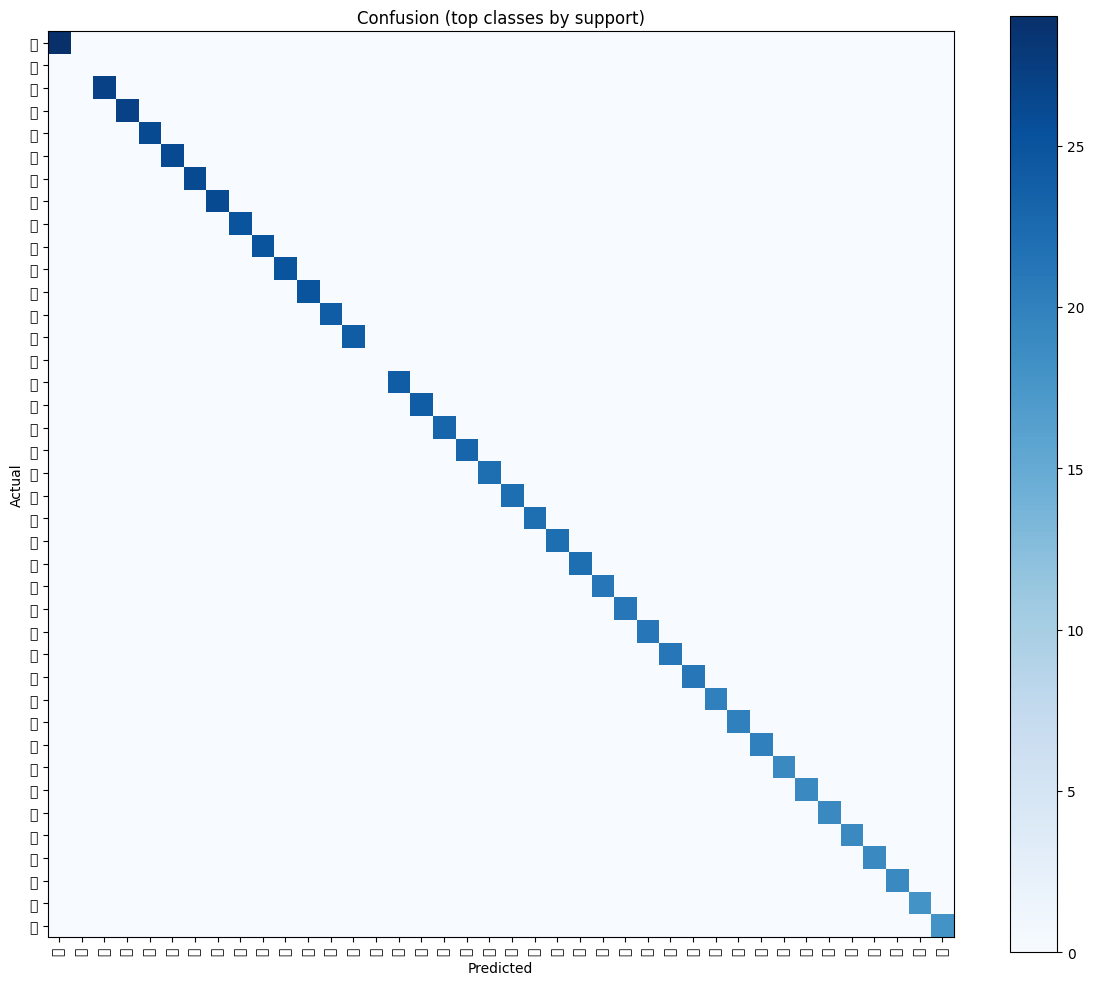

c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2406 (\N{DEVANAGARI DIGIT ZERO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\acer\OneDrive\Desktop\OCR\devangari-ocr\.venv\Lib\site-p

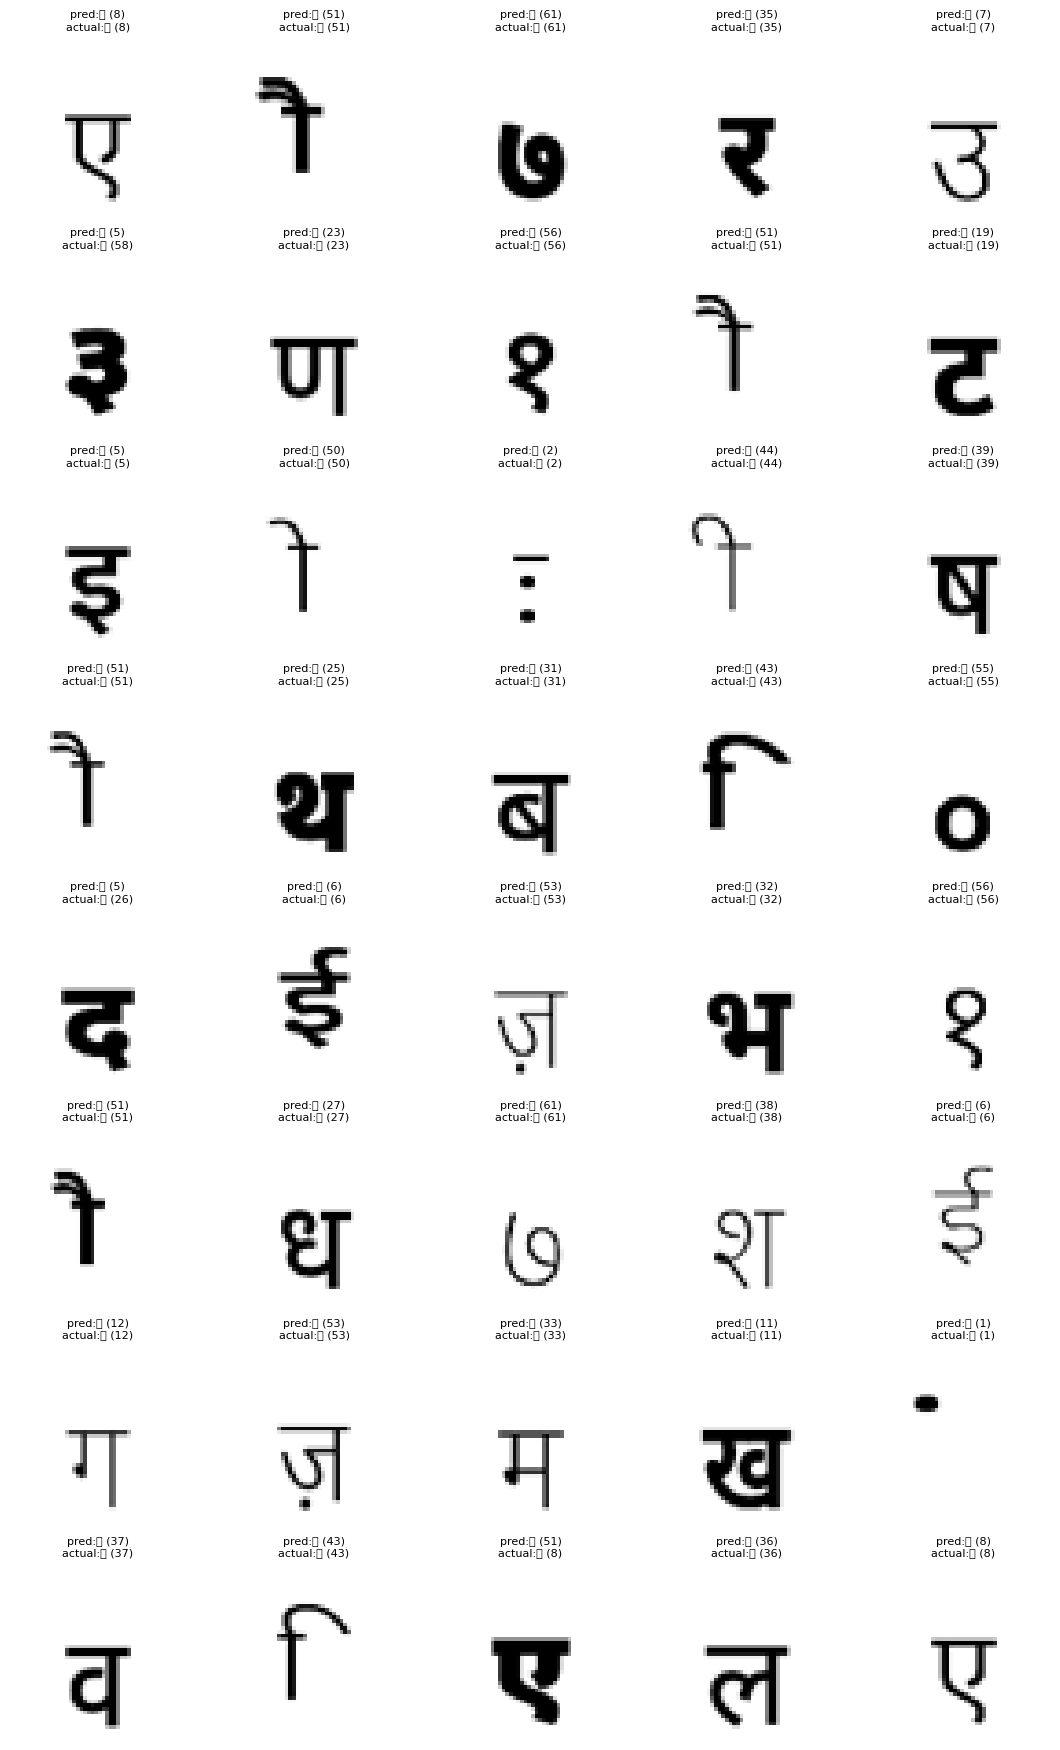

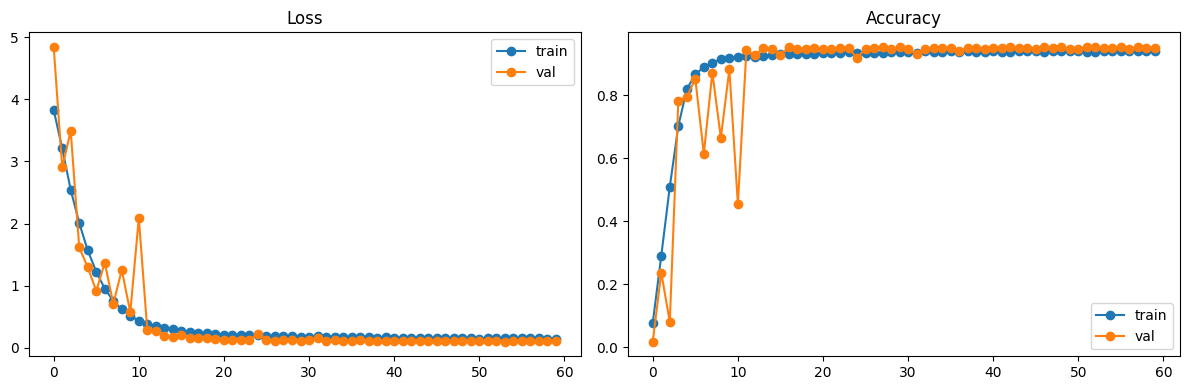

In [7]:
# Run a large training session to improve generalization
# WARNING: this can be time-consuming on CPU. If you have a GPU it's used automatically.

image_dir = 'data/char_images'
# Larger dataset and resolution
samples_per_char = 200   # large dataset
epochs = 60              # longer training
batch_size = 256
lr = 1e-3
split = (0.8, 0.1, 0.1)
img_size = 48

# Regenerate dataset (overwrite=True) to ensure we have the larger, high-res images
train_char_cnn(image_dir=image_dir, samples_per_char=samples_per_char, epochs=epochs, batch_size=batch_size, lr=lr, split_ratios=split, img_size=img_size, overwrite=True)

# Load best model and print clearer predictions table (human-readable characters)
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('char_cnn_best.pth', map_location=device)
charset = ckpt['charset']
num_classes = len(charset)
model = CharCNN(num_classes=num_classes).to(device)
model.load_state_dict(ckpt['model_state'])
model.eval()

# show mapping header
print('Index -> Character mapping (first 120 indices):')
for i, ch in enumerate(charset[:120]):
    print(f"{i}: {ch}")

# textual predictions vs actual for 60 test samples
_, _, test_files = create_splits(image_dir=image_dir, ratios=split, seed=42)
sample_files = test_files[:60]

print('\nFilename | Actual (idx) | Predicted (idx)')
for p in sample_files:
    img = Image.open(p).convert('L')
    t = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        pred_idx = out.argmax(1).item()
    actual_idx = int(os.path.basename(p).split('__')[1].split('.')[0])
    print(f"{os.path.basename(p)} | {charset[actual_idx]} ({actual_idx}) | {charset[pred_idx]} ({pred_idx})")

print('\nArtifacts written: char_cnn_best.pth, char_cnn.pth, char_training_history.png, char_confusion.png, sample_preds.png')


In [40]:
import torch
from PIL import Image
from torchvision import transforms
from model.ocr_model import OCRModel
import yaml

def load_config():
    with open("config.yaml", "r") as f:
        return yaml.safe_load(f)

def load_charset(charset_path="charset.txt"):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
        return list(chars)

def ctc_greedy_decoder(preds, charset):
    preds = preds.softmax(2)
    preds = preds.argmax(2).transpose(0, 1)
    decoded_texts = []
    for pred in preds:
        text = []
        previous = None
        for p in pred:
            if p != 0 and p != previous:  # blank index 0
                text.append(charset[p])
            previous = p
        decoded_texts.append("".join(text))
    return decoded_texts

def preprocess_image(image_path, img_height=32):
    img = Image.open(image_path).convert("L")
    w, h = img.size
    new_w = int(w * (img_height / h))
    img = img.resize((new_w, img_height), Image.BICUBIC)
    transform = transforms.ToTensor()
    img = transform(img)
    return img.unsqueeze(0)

def inference(image_path, model_path, charset_path="charset.txt"):
    cfg = load_config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = OCRModel(
        num_classes=cfg["num_classes"],
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    charset = load_charset(charset_path)

    img = preprocess_image(image_path).to(device)
    with torch.no_grad():
        preds = model(img)
        texts = ctc_greedy_decoder(preds, charset)
    return texts[0]

if __name__ == "__main__":
    img_path = "test_image.png"
    model_path = "ocr_model.pth"
    result = inference(img_path, model_path)
    print("Predicted text:", result)


Predicted text: 




In [45]:
import torch
from PIL import Image
from torchvision import transforms
from model.ocr_model import OCRModel
import yaml

# ------------------------------
# CONFIG LOADING
# ------------------------------
def load_config():
    with open("config.yaml", "r") as f:
        return yaml.safe_load(f)

# ------------------------------
# LOAD CHARSET
# ------------------------------
def load_charset(charset_path="charset.txt"):
    with open(charset_path, "r", encoding="utf-8") as f:
        chars = f.read().strip()
        return list(chars)

# ------------------------------
# CTC GREEDY DECODER
# ------------------------------
def ctc_greedy_decoder(preds, charset):
    """
    preds: (seq_len, batch, num_classes)
    charset: list of characters excluding blank (index 0)
    """
    preds = preds.softmax(2)
    preds_argmax = preds.argmax(2)  # (seq_len, batch)
    preds_argmax = preds_argmax.transpose(0, 1)  # (batch, seq_len)

    decoded_texts = []
    for pred in preds_argmax:
        text = []
        prev = None
        for p in pred:
            if p != 0 and p != prev:  # 0 = blank
                text.append(charset[p - 1])  # subtract 1 if blank=0
            prev = p
        decoded_texts.append("".join(text))
    return decoded_texts, preds_argmax

# ------------------------------
# IMAGE PREPROCESS
# ------------------------------
def preprocess_image(image_path, img_height=32, img_width=128, img_channels=1):
    img = Image.open(image_path).convert("L")  # always grayscale
    w, h = img.size

    # Resize height to match CRNN
    new_w = int(w * (img_height / h))
    img = img.resize((new_w, img_height), Image.BICUBIC)

    # Pad or crop width
    if new_w < img_width:
        new_img = Image.new("L", (img_width, img_height), 255)
        new_img.paste(img, (0, 0))
        img = new_img
    else:
        img = img.crop((0, 0, img_width, img_height))

    # To tensor
    transform = transforms.ToTensor()  # 0..1
    tensor = transform(img)  # [C, H, W]

    # Repeat channels if needed
    if img_channels == 3:
        tensor = tensor.repeat(3, 1, 1)

    return tensor.unsqueeze(0)  # [1, C, H, W]

# ------------------------------
# INFERENCE FUNCTION
# ------------------------------
def inference(image_path, model_path, charset_path="charset.txt"):
    cfg = load_config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = OCRModel(
        num_classes=cfg["num_classes"],
        img_channels=cfg["num_channels"],
        hidden_size=cfg["hidden_size"]
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load charset
    charset = load_charset(charset_path)

    # Preprocess image
    img = preprocess_image(image_path,
                           img_height=cfg.get("img_height", 32),
                           img_width=cfg.get("img_width", 128),
                           img_channels=cfg["num_channels"]).to(device)

    # Forward pass
    with torch.no_grad():
        preds = model(img)  # (seq_len, batch, num_classes)
        decoded_texts, argmax = ctc_greedy_decoder(preds, charset)

    # DEBUG: print raw argmax
    print("Raw argmax indices:", argmax.squeeze().cpu().numpy())
    print("Decoded text:", decoded_texts[0])
    return decoded_texts[0]

# ------------------------------
# RUN INFERENCE
# ------------------------------
if __name__ == "__main__":
    img_path = "test_image_2.jpg"
    model_path = "ocr_model.pth"
    result = inference(img_path, model_path)
    print("Predicted text:", result)


Raw argmax indices: [49  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]
Decoded text: तठ
Predicted text: तठ
